<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/76_Lite_Pytorch_%D0%A7%D0%B0%D1%81%D1%82%D1%8C_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Макс 10 баллов
 
Используйте готовый ноутбук

1. Возьмите любые 10 изображений. Напишите свой класс для создания Dataset, в который на вход будут подаваться: путь с файлами, listID, labels. При этом изображения должны быть на выходе (xTrain) ч/б, перевернутые, урезанные до размера (32х32) и вытянутые в вектор.

2. Напишите архитектуру сетки, которая будет обрабатывать данные из пункта 1.

3. Напишите процесс обучения для такой архитектуры, используйте loss, criterion и optimizer не из занятия.

In [ ]:
# Этим блоком будем визуализировать
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import scipy

# Библиотеки Pytorch
import torch 
import torchvision # здесь лежат mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms # библиотека для преобразования изображений
import torchvision.datasets as dsets # работа с классом Датасет

# Вывод информации о модели
from torchsummary import summary

# Визуализации графа
from torch.utils.tensorboard import SummaryWriter 
import datetime, os
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Создание собственного набора данных

# Подготовка собственных данных



In [ ]:
# Используем готовый data loader от torch
path = '/content/drive/MyDrive/Базы/own_dataset/' 
listID = os.listdir(path)
labels = [0,1,2,3,4,5,6,7,8,9]
print(listID)

['0.jpeg', '1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg']


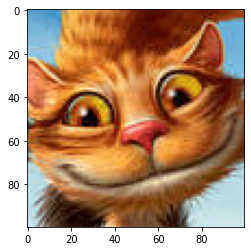

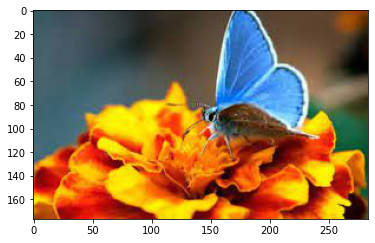

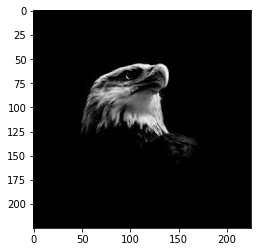

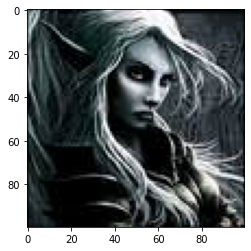

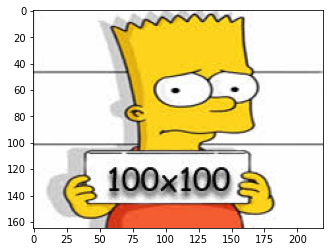

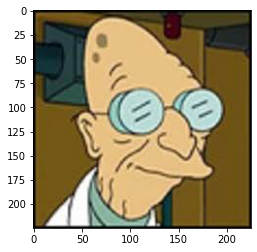

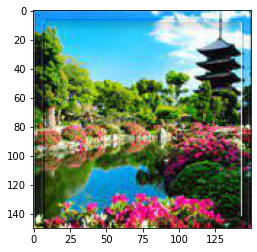

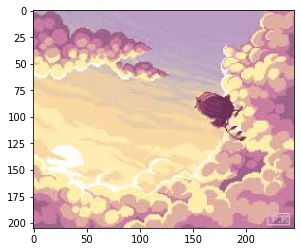

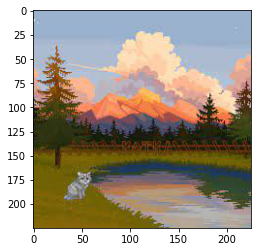

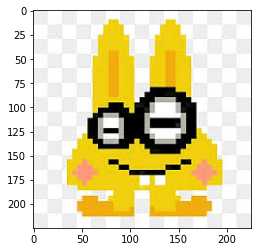

In [ ]:
for i in listID:
  plt.imshow(Image.open(path + i))
  plt.show()

In [ ]:
# Создаем класс для собственных данных, наследуя свойства стандартного датасета
class CustomDataset(data.Dataset):
    def __init__(self, listID, labels, path, transforms = None): 
        # Инициализируем атрибуты (они абсолютно произвольные. У вас они могут быть совсем другими)
        self.listID = listID # listID список имен каждого экземпляра
        self.labels = labels # labels - то, что скормим как yTrain
        self.transforms = transforms # если нужны какие-то преобразования
        self.path = path # путь, где лежат данные
        

    def __getitem__(self, index):        
        # В этом методе указывается то, как будут извлекаться данные при очередном обращении в цикле обучения
        # Открываем папку с данными (можно использовать numpy.fromfile, PIL.Image.open)
        ID = self.listID[index] # итерируем по каждому элементу в списке
        image = Image.open(path + ID) # извлекаем картинку по его ID

        # Если transforms заполнено, то:
        if self.transforms:
            image = self.transforms(image) # то, что лежит в transforms применяем к картинку
        trainX = image # наша картинка уходит в xTrain для этой итерации
        trainY = self.labels[index] # лейбл для этой картинки уходит в yTrain
        
        # Возвращаем пару экзмепляр-метка
        return trainX, trainY

    def __len__(self):
        # Здесь общий размер вашего датасета
        return len(listID)

In [ ]:
# Пример последовательности трансфорирмирования для изображений
transform = transforms.Compose([
        transforms.RandomResizedCrop((32,32)), # произвольное обрезание картинки
        transforms.RandomHorizontalFlip(p=0.5), # перевернуть/отразить по горизонтали
        transforms.Grayscale(num_output_channels=1), # ч/б
        transforms.ToTensor()]) # преобразование в тензор (иначе никак)


In [ ]:
customData = CustomDataset(listID,labels,path,transform)

trainLoader = torch.utils.data.DataLoader(dataset=customData,
                                           batch_size=2, 
                                           shuffle=True,
                                           num_workers=4)

In [ ]:
dataiter = iter(trainLoader)
trainX, trainY = next(dataiter)
trainX[0].shape

torch.Size([1, 32, 32])

# Архитектура модели



In [ ]:
# Создадим переменную, в которой будет храниться тип устройства (GPU или CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
inputSize = 1024      # Размер входных данных
numClasses = 10      # Количество классов
numEpochs = 10       # Количество эпох
learningRate = 0.001 # Скорость обучения
hidden = 500         # Размер скрытого слоя

In [ ]:
# Создаем класс
class Classification(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__() # наследуем все свойства + добавляем свое
        self.layer1 = nn.Linear(inputSize, hidden_size) # первый слой - линейный
        self.relu = nn.ReLU() 
        self.layer2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1) # Поскольку задача классификации, то используется функция активации softmax

    def forward(self, x): # Здесь мы прописываем принципы, по которым данные будут проходить через сеть
        out = self.layer1(x)  # выход первого слоя
        out = self.relu(out) # применяем функцию активации к выходу первого слоя
        out = self.layer2(out) # передаем это во второй слой
        out = self.softmax(out) # применяем функцию активации ко второму слою
        return out

model = Classification(inputSize, hidden, numClasses).to(device) # Создаем объект нашей полносвязной сети

In [ ]:
summary(model, (inputSize,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         512,500
              ReLU-2                  [-1, 500]               0
            Linear-3                   [-1, 10]           5,010
           Softmax-4                   [-1, 10]               0
Total params: 517,510
Trainable params: 517,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.97
Estimated Total Size (MB): 1.99
----------------------------------------------------------------


In [ ]:
trainX.view(-1, 32*32).shape # view операция идентичная reshape, за исключением, что она меняет размер массива только для данной итерации

torch.Size([2, 1024])

In [ ]:
trainX.size()

torch.Size([2, 1, 32, 32])

# Функция ошибки и оптимизатор



In [ ]:
criterion = nn.CrossEntropyLoss() # функция ошибки
optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate) # оптимизатор
losses = [] # сюда будет добавляться средняя ошибка. Список будем использовать для построения графика
model.train() # переход в режим обучения

Classification(
  (layer1): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=500, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

# Обучаем модель



Эпоха: [1/10], Ошибка: 2.4193
Эпоха: [2/10], Ошибка: 2.2177
Эпоха: [3/10], Ошибка: 2.2192
Эпоха: [4/10], Ошибка: 2.1812
Эпоха: [5/10], Ошибка: 2.2863
Эпоха: [6/10], Ошибка: 2.3085
Эпоха: [7/10], Ошибка: 2.3258
Эпоха: [8/10], Ошибка: 2.2303
Эпоха: [9/10], Ошибка: 2.4100
Эпоха: [10/10], Ошибка: 2.5070


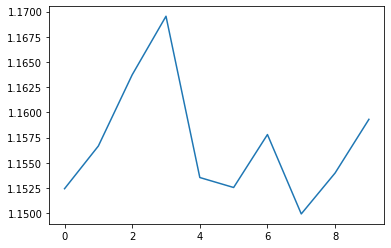

In [ ]:
for epoch in range(numEpochs): # количество эпох
    lossTot = 0 # потери в совокупности

    for i, (images, labels) in enumerate(trainLoader): # проходимся по всем данным в batch
        images = images.view(-1, 32*32).to(device)     # приводим к правильному формату для сетки
        labels = labels.to(device)                    # отправляем метки на используемое устройство
        optimizer.zero_grad()                          # обнуляем градиент
        outputs = model(images)                        # здесь наше предсказание
        loss = criterion(outputs.log(), labels)        # считаем ошибку 
        
        loss.backward()                                # обратное распространение ошибки 
                                                       # x.grad += dloss/dx для всех параметров x

        lossTot += loss.cpu().detach().data # инкремент ошибки
        
        optimizer.step() # следующий шаг спуска

    losses.append(lossTot/len(customData)) # вычисляем среднюю ошибку и добавляем в список
    print('Эпоха: [%d/%d], Ошибка: %.4f' 
           % (epoch+1, numEpochs, loss))
plt.plot(losses) # График нашего обучения

# **Глоссарий**
*   **train dataset** - объект, включающий в себя ваш набор данных. На выходе такого объекта всегда должен быть тензор.
*   **train loader** - объект, в который вы подгружаете ваш train dataset, и который используете при обучении нейронной сети для итерирования по всему набору данных. 
*   **optimizer.zero_grad()** - обнуляет результат дифференциирования.
*   **loss.backward()** - считает градиент для обратного распространения ошибки. 
*   **optimizer.step()** - принимает (автоматически) посчитанные градиенты и делает шаг оптимизации.
*   **nn.Module** - базовый класс нейронной сети, на котором строится собственная нейронная сеть.
*   **def forward(self,x)** - функция-движитель. Связывает инициализированные слои. На вход принимается х (batch) и передается дальше по всем слоям.
*   **data.Dataset** -  базовый класс дата сета, на котором строится собственный датасет.
*   **.view()** - функция, интерпретирующая размер объекта для данной итерации в том виде, который указан в качестве параметра.
*   **.data** - получить исключительно статичные данные из тензора.
*   **.detach()** - открепить тензор от вычислительного графа.
*   **model.train()** - перевести объект нейронки в обучающи режим.
*   **model.eval()** - перевести объект нейронки в режим оценки.

# **Обратите внимание**

*   В параметрах тензора вы можете вручную прописать поддержку дифференциирования
*   Для удобства всегда создавайте DataLoader. Для DataLoader необходим Dataset
*   Dataset всегда можно прописать "вручную"
*   Прописываете архитектуру модели через отдельный класс
*   Выбирая функцию ошибки, смотрите, какой формат должен подаваться на вход
*   Во время обучения не забывайте о последовательности .zero_grad -> .backward -> .step
*   Режимы тренировочный и оценочный являются *разными* для Pytorch. Не забывайте указывать это в начале.    


